# Exploring and cleaning the dataset

In [125]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
%matplotlib inline

The dataset consists on two files:
- outcomes.tsv: this file contains the result for different auctions, including the description of the product, its retail price and selling price, the winnner of the auction, the number of placed bids, etc.
- traces.tsv: this file contains the record of all of the bids that were placed for several auctions, including the user who placed each bid, the bidding time, etc.

The dataset can be found in the following link:
http://people.bu.edu/zg/swoopo.html

Dataset authors:

John Byers, Michael Mitzenmacher, Georgios Zervas,
"Information Asymmetries in Pay-Per-Bid Auctions: How Swoopo Makes Bank"

In [126]:
outcomesDf = pd.read_csv('./outcomes.tsv',sep='\t')
tracesDf = pd.read_csv('./traces.tsv',sep='\t')

# outcomes.tsv

The file outcomes.tsv included in the dataset contains the following columns:

- auction_id: unique numerical id for the auction
- product_id: unique product id
- item: text string describing the product
- desc: more information about the product
- retail: the stated retail value of the item, in dollars
- price: the price the auction reached, in dollars
- finalprice: the price charged to the winner in dollars. For certain types of auctions, the value in this column may difer from the value specified in column "price". For example, this may happend in fixed-price auctions or 100%-off auctions (auctions in which the final selling price of the product is zero, and the revenue for Swoopo comes exclusively from the bids that are placed).
- bidincrement: the price increment of a bid, in cents
- bidfee: the cost incurred to make a bid, in cents
- winner: the winner's username
- placedbids: the number of paid bids placed by the winner
- freebids: the number of free bids placed by the winner. Limited free bids are offered by Swoopo in certain deal packages, and users placing free bids do not incur in any bid cost.
- endtime_str: the auction's end time.
- flg_click_only: a binary flag indicating a ``NailBiter'' auction (Swoopo  auctions  which  do  not
permit the use of automated bids by a BidButler, which are automatic bidding agents provided by the Swoopo interface that bid according to user-defined instructions. Users are able to define starting and ending price limits for which automated bids shall be placed, as well as the top number of bids that the BidButler is allowed to place. BidButlers place automated bids when the auction timer drops below 10 seconds).
- flg_beginnerauction: a binary flag indicating a beginner auction (auctions restricted to users who haven't previously won any auction in the site).
- flg_fixedprice: a binary flag indicating a fixed-price auction (an auction in which the selling price is fixed from the beginning). 
- flg_endprice: a binary flag indicating a 100\%-off auction (auctions in which the final selling price of the product is zero, and the revenue for Swoopo comes exclusively from the bids that are placed).

In [13]:
outcomesDf.head(2)

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,15,75,Racer11,26,0,19:52 PDT 09-16-2008,0,0,0,0
1,87964,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,74.70,74.70,15,75,Cemo23,65,0,11:17 PDT 08-28-2008,0,0,0,0


In [14]:
outcomesDf.dtypes

auction_id               int64
product_id               int64
item                    object
desc                    object
retail                 float64
price                  float64
finalprice             float64
bidincrement             int64
bidfee                   int64
winner                  object
placedbids               int64
freebids                 int64
endtime_str             object
flg_click_only           int64
flg_beginnerauction      int64
flg_fixedprice           int64
flg_endprice             int64
dtype: object

In [127]:
outcomesDf['endtime_str'] = pd.to_datetime(outcomesDf['endtime_str'])

The number of bids that were placed in the auction can be obtained the price the auction reached and the price increment of each bid:

In [128]:
outcomesDf['bids_placed'] = outcomesDf['price']/(outcomesDf['bidincrement']/100)

The total money that Swoopo obtains for an auction is the number of non-free bids placed by all participants multiplied by the bid fee, plus the final selling price of the item paid by the winner:

In [129]:
outcomesDf['swoopo_sale_price'] = outcomesDf['bids_placed']*(outcomesDf['bidfee']/100) + outcomesDf['finalprice']

Therefore, the profit that Swoopo obtains over the retail price of the item is:

In [130]:
outcomesDf['swoopo_profit'] = outcomesDf['swoopo_sale_price']-outcomesDf['retail']

The dataset file includes 121419 auctions that took place between 2008-08-20 and 2009-12-12

In [21]:
outcomesDf.shape

(121419, 18)

In [19]:
min(outcomesDf['endtime_str'])

Timestamp('2008-08-20 14:04:00')

In [20]:
max(outcomesDf['endtime_str'])

Timestamp('2009-12-12 15:10:00')

In order to identify the different items sold in the auctions, the columns "product_id", "item" and "desc" can be used. An analysis of the unique values contained in these columns is now performed. Each one of them contains a different number of unique values. 

In [82]:
len(outcomesDf['product_id'].unique())

2081

In [83]:
len(outcomesDf['item'].unique())

1803

In [84]:
len(outcomesDf['desc'].unique())

1779

In [131]:
def compareProductIdItemDescColumnValues():
    outcomesDfItemDesc =outcomesDf[['product_id','item','desc','endtime_str']]
    productIdColumnValueCounts = outcomesDf['product_id'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(productIdColumnValueCounts.to_frame(),how='left',left_on='product_id',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'product_id_x': 'product_id', 'product_id_y': 'product_id_count'})

    itemColumnValueCounts = outcomesDf['item'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(itemColumnValueCounts.to_frame(),how='left',left_on='item',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'item_x': 'item', 'item_y': 'item_count'})

    descColumnValueCounts = outcomesDf['desc'].value_counts()
    outcomesDfItemDesc = outcomesDfItemDesc.merge(descColumnValueCounts.to_frame(),how='left',left_on='desc',right_index=True)
    outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'desc_x': 'desc', 'desc_y': 'desc_count'})
    
    return outcomesDfItemDesc

outcomesDfItemDesc = compareProductIdItemDescColumnValues()
outcomesDfItemDesc.head()

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
0,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-16 19:52:00,10,77,77
1,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,2008-08-28 11:17:00,21,60,60
2,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,2008-11-07 22:52:00,21,60,60
3,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-23 22:02:00,33,77,77
4,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-24 14:23:00,33,77,77


As it can be observed, the product_id contains different values for rows of the dataset in which the same item is sold. Therefore, the "product_id" value is not a good option to identify unique products.

In [132]:
productIdVsItemDf = outcomesDfItemDesc[(outcomesDfItemDesc['product_id_count']!=outcomesDfItemDesc['item_count'])].drop_duplicates(subset=['product_id','item','desc'])
productIdVsItemDf.shape

(569, 7)

Here is an example:

In [97]:
productIdVsItemDf[productIdVsItemDf['item'].values == 'sony-ericsson-s500i-unlocked-mysterious-']

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
0,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-16 19:52:00,10,77,77
3,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-23 22:02:00,33,77,77
5,10008975,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-08-22 22:44:00,15,77,77
17,10009642,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-09-02 00:06:00,11,77,77
17297,10010727,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,2008-11-11 01:46:00,8,77,77


As it can be seen, some items do not contain a description, and the "item" column is the name of an HTML page:

In [133]:
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
19906,10010818,121881.html,-,2008-11-26 18:03:00,36,1,36
19294,10010818,121215.html,-,2008-11-22 20:04:00,36,1,36
19540,10010818,121470.html,-,2008-11-18 22:01:00,36,1,36
19837,10010818,121788.html,-,2008-11-24 13:05:00,36,1,36
21170,10010818,123276.html,-,2008-11-28 14:25:00,36,1,36
21421,10010818,123553.html,-,2008-11-30 23:24:00,36,1,36
22803,10010818,125284.html,-,2008-12-07 17:10:00,36,1,36
22804,10010818,125285.html,-,2008-12-05 13:18:00,36,1,36
22805,10010818,125286.html,-,2008-12-03 19:51:00,36,1,36
22806,10010818,125287.html,-,2008-12-02 16:39:00,36,1,36


This is the case for 36 rows in the dataframe.

In [134]:
itemVsDescDf[itemVsDescDf.apply(lambda x : "html" in x['item'], axis=1)]

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
19906,10010818,121881.html,-,2008-11-26 18:03:00,36,1,36
19294,10010818,121215.html,-,2008-11-22 20:04:00,36,1,36
19540,10010818,121470.html,-,2008-11-18 22:01:00,36,1,36
19837,10010818,121788.html,-,2008-11-24 13:05:00,36,1,36
21170,10010818,123276.html,-,2008-11-28 14:25:00,36,1,36
21421,10010818,123553.html,-,2008-11-30 23:24:00,36,1,36
22803,10010818,125284.html,-,2008-12-07 17:10:00,36,1,36
22804,10010818,125285.html,-,2008-12-05 13:18:00,36,1,36
22805,10010818,125286.html,-,2008-12-03 19:51:00,36,1,36
22806,10010818,125287.html,-,2008-12-02 16:39:00,36,1,36


Since auctions with missing product descriptions would not be very helpful for the analysis, and this only happens for a small number of rows, it has been decided to discard these rows.

In [135]:
htmlItems = ['109104.html', '109746.html', '109786.html', '109830.html',
       '110013.html', '110869.html', '111506.html', '111584.html',
       '112103.html', '112187.html', '114652.html', '114804.html',
       '114907.html', '116626.html', '117910.html', '118838.html',
       '121129.html', '121215.html', '121470.html', '121471.html',
       '121788.html', '121881.html', '123276.html', '123553.html',
       '125284.html', '125285.html', '125286.html', '125287.html',
       '125288.html', '126865.html', '126866.html', '126867.html','130108.html',
       '137897.html', '137898.html', '140035.html']
outcomesDf = outcomesDf[~outcomesDf['item'].isin(htmlItems)]

In most of the cases in which there are different values in the column "desc" for the same value of the column "item", it is due to small grammar differences in the text contained in the column "desc":

In [136]:
outcomesDfItemDesc = compareProductIdItemDescColumnValues()
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
30862,10011491,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera,2009-01-05 02:42:00,43,48,43
25280,10010929,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera - RED,2008-12-10 13:43:00,5,48,5
52065,10011838,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-03-15 17:43:00,6,21,6
60454,10012069,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-04-17 21:05:00,8,21,15
7691,10009192,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 ( 5/8"" Inch)",2008-10-06 13:23:00,26,37,26
17351,10011006,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 (5/8"" Inch)",2008-11-08 11:47:00,11,37,11
77943,10012229,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-29 04:30:00,22,37,22
74852,10012230,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-15 07:13:00,15,37,15
506,10008900,lego-city-7743-police-command-center,LEGO City 7743 - Police Command Center,2008-08-21 23:23:00,3,6,3
7652,10010875,lego-city-7743-police-command-center,LEGO City 7743: Police Command Center,2008-10-03 18:48:00,3,6,3


For example, for the item "vtech-v-smile-tv-learning-system" there are two descriptions that actually refer to the same item, but are written slightly differently:

In [139]:
itemVsDescDf[itemVsDescDf['item'].values == "vtech-v-smile-tv-learning-system"]

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
503,10009529,vtech-v-smile-tv-learning-system,VTech V.Smile TV Learning System,2008-08-23 05:53:00,4,22,4
13766,10011031,vtech-v-smile-tv-learning-system,Vtech - V.Smile TV Learning System,2008-11-03 04:59:00,18,22,18


The following code lines are used to clean these small differences:

In [ ]:
outcomesDf.loc[outcomesDf['item'].values=="vtech-v-smile-tv-learning-system", 'desc'] = "Vtech - V.Smile TV Learning System"
outcomesDf.loc[outcomesDf['item'].values=="lego-city-7743-police-command-center", 'desc'] = "LEGO City 7743 - Police Command Center"
outcomesDf.loc[outcomesDf['item'].values=="samsung-t220hd-22-1080p-lcd-hdtv-monitor", 'desc'] = "Samsung T220HD 22\" 1080p LCD HDTV Monitor"
outcomesDf.loc[outcomesDf['item'].values=="ghd-professional-mini-styler-mk4-5-8-inc", 'desc'] = "GHD Professional Mini Styler MK4 (5/8\" Inch)"
outcomesDf.loc[outcomesDf['item'].values=="frigidaire-atf8000fs-white-front-loading", 'desc'] = "Frigidaire ATF8000FS White Front-Loading Washer"
outcomesDf.loc[outcomesDf['item'].values=="lg-26-5-cu-ft-side-by-side-refrigerator-", 'desc'] = "LG 26.5 cu.ft. Side-By-Side Refrigerator (White)"
outcomesDf.loc[outcomesDf['item'].values=="samsung-bd-p3600-1080p-blu-ray-disc-play", 'desc'] = "Samsung BD-P3600 1080p Blu-Ray Disc Player"
outcomesDf.loc[outcomesDf['item'].values=="garmin-n-vi-205w-4-3-inch-portable-gps-n", 'desc'] = "Garmin nüvi 205W 4.3-Inch Portable GPS Navigator"
outcomesDf.loc[outcomesDf['item'].values=="casio-exilim-ex-z200-10-1-mp-digital-cam", 'desc'] = "Casio Exilim EX-Z200 10.1 MP Digital Camera"

In [141]:
outcomesDfItemDesc = compareProductIdItemDescColumnValues()
itemVsDescDf = outcomesDfItemDesc[(outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count'])].drop_duplicates(subset=['item','desc'])
itemVsDescDf = itemVsDescDf.sort_values(by='desc')
itemVsDescDf

,product_id,item,desc,endtime_str,product_id_count,item_count,desc_count
30862,10011491,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera,2009-01-05 02:42:00,43,48,43
25280,10010929,casio-exilim-ex-z200-10-1-mp-digital-cam,Casio Exilim EX-Z200 10.1 MP Digital Camera - RED,2008-12-10 13:43:00,5,48,5
52065,10011838,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-03-15 17:43:00,6,21,6
60454,10012069,frigidaire-atf8000fs-white-front-loading,Frigidaire ATF8000FS White Front-Loading Washer,2009-04-17 21:05:00,8,21,15
7691,10009192,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 ( 5/8"" Inch)",2008-10-06 13:23:00,26,37,26
17351,10011006,ghd-professional-mini-styler-mk4-5-8-inc,"GHD Professional Mini Styler MK4 (5/8"" Inch)",2008-11-08 11:47:00,11,37,11
77943,10012229,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-29 04:30:00,22,37,22
74852,10012230,garmin-n-vi-205w-4-3-inch-portable-gps-n,Garmin nüvi 205W 4.3-Inch Portable GPS Navigator,2009-06-15 07:13:00,15,37,15
506,10008900,lego-city-7743-police-command-center,LEGO City 7743 - Police Command Center,2008-08-21 23:23:00,3,6,3
7652,10010875,lego-city-7743-police-command-center,LEGO City 7743: Police Command Center,2008-10-03 18:48:00,3,6,3


In [8]:
len(outcomesDf['winner'].unique())

45787

In [6]:
outcomesDfItemDesc =outcomesDf[['item','desc']]
outcomesDfItemDesc.head()
outcomesDfItemDesc.shape
itemColumnValueCounts = outcomesDf['item'].value_counts()
itemColumnValueCounts.head()
outcomesDfItemDesc.shape
outcomesDfItemDesc = outcomesDfItemDesc.merge(itemColumnValueCounts.to_frame(),how='left',left_on='item',right_index=True)
outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'item_x': 'item', 'item_y': 'item_count'})
outcomesDfItemDesc.shape
outcomesDfItemDesc
descColumnValueCounts = outcomesDf['desc'].value_counts()
descColumnValueCounts.head()
outcomesDfItemDesc = outcomesDfItemDesc.merge(descColumnValueCounts.to_frame(),how='left',left_on='desc',right_index=True)
outcomesDfItemDesc = outcomesDfItemDesc.rename(columns={'desc_x': 'desc', 'desc_y': 'desc_count'})
outcomesDfItemDesc.shape
outcomesDfItemDesc.head()
outcomesDfItemDesc[outcomesDfItemDesc['item_count']!=outcomesDfItemDesc['desc_count']]['item'].unique()

array(['mario-sonic-at-the-olympic-winter-games-',
       'star-wars-the-clone-wars-republic-heroes'], dtype=object)

In [15]:
outcomesDfItemDesc[outcomesDfItemDesc['item'].values=="casio-exilim-ex-z200-10-1-mp-digital-cam"]['desc'].unique()

array(['Casio Exilim EX-Z200 10.1 MP Digital Camera - RED',
       'Casio Exilim EX-Z200 10.1 MP Digital Camera'], dtype=object)

In [8]:
for itemdesc in outcomesDf['desc'].unique():
    print(itemdesc)

Sony Ericsson S500i Unlocked Mysterious Green
PSP Slim & Lite Sony Piano Black
iPod Touch Apple 8GB with Software Upgrade
LG KU990 Viewty Unlocked Black
Logitech Cordless Wave Keyboard and Mouse
Apple Macbook Air 1.6GHz Core 2 Duo Notebook
SanDisk Cruzer Contour 4GB
Mario Kart with Wheel (Nintendo Wii)
PS3 | Playstation 3 Sony Console 40GB HDD
DS | Nintendo DS Lite White
Sony Ericsson P1i Unlocked
LG Electronics KE850 Prada Unlocked Black
Nokia N95 8 GB Unlocked Black
Acer Aspire AS6920-6508 16" Core 2 Duo Notebook
Corsair Voyager Mini 4 GB USB Flash
Asus Eee PC 900 XP White
Super Smash Bros. Brawl (Nintendo Wii)
DS | Nintendo DS Lite Black
Apple iPod Shuffle 2GB Silver 2nd Gen
Canon Digital Rebel XSi + 18-55mm Lens Black
Apple iPod Shuffle 1GB Silver 2nd Gen
Toshiba Regza 37RV530U 37" 1080p LCD HDTV
Microsoft Xbox 360 Deluxe Bundle + Forza  2
DS | Nintendo DS Lite (pink)
Wii | Nintendo Console + Wii Sports
Samsung PN50A450 50" HDTV Plasma TV
DS | Nintendo DS Lite (Crimson Red and Blac

KitchenAid 11" Round Grill and 10" Round Griddle
LEGO BIONICLE 8990: Fero and Skirmix
Virtua Tennis 2009 (PS3)
Indiana Jones and the Staff of Kings (Wii)
Guitar Hero World Tour Guitar Kit (Wii)
Virtua Tennis 2009 (Wii)
UFC 2009: Undisputed (PS3)
EA Sports Active (Wii)
Summer Sports Paradise (Wii)
Logitech Digital Precision PC Gaming Headset
Samsung 2333SW 23-Inch Full HD LCD Monitor
Logitech Optical USB mouse
Verbatim DVD-R 4.7GB 16X Branded (50 pack)
Apple MacBook MB881LL/A 13.3-Inch Laptop
Samsung N120 10.1-Inch Netbook (White)
Wii Wireless Sensor Bar
Vanguard VT-214 Aluminum Digital Camera Tripod
Cables To Go Velocity Series 40315 HDMI Cable
Samsung LN40B550 40-Inch 1080p LCD HDTV
Perigaum Moonwalker Chronograph
Perigaum Flightmaster Chronograph
Bossart Automatic Watch Réctangulaire
Super Solano 232 1875 Watt Professional Hair Dryer
TRESemme Philips Thermal Creations Straightener
Archos 2 Video MP3 Player 16 GB (Black)
HP Pavilion Elite M9520F Desktop PC
Belkin Geo Sleeve Notebook c

In [10]:
outcomesDf.head()

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,15,75,Racer11,26,0,19:52 PDT 09-16-2008,0,0,0,0
1,87964,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,74.70,74.70,15,75,Cemo23,65,0,11:17 PDT 08-28-2008,0,0,0,0
2,87965,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,83.10,83.10,15,75,Jacobsonnich,94,0,22:52 PDT 11-07-2008,0,1,0,0
3,88638,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,19.65,19.65,15,75,Mokkis,10,0,22:02 PDT 08-23-2008,0,0,0,0
4,88639,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,47.10,47.10,15,75,Superloeffel,80,0,14:23 PDT 08-24-2008,0,0,0,0


In [11]:
productCategoriesDf = pd.read_excel('./product_categories.xlsx')
productCategoriesDf.head()

,item,desc,link,category
0,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,https://www.amazon.com/Sony-Ericsson-S500i-Slo...,Cell Phones & Accessories › Cell Phones › Unlo...
1,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,https://www.amazon.com/Sony-PSP-Slim-Lite-2000...,Video Games › Sony PSP › Consoles
2,ipod-touch-apple-8gb-with-software-upgra,iPod Touch Apple 8GB with Software Upgrade,https://www.amazon.com/Apple-touch-Generation-...,Electronics › Portable Audio & Video › MP3 & M...
3,lg-ku990-viewty-unlocked-black,LG KU990 Viewty Unlocked Black,https://www.amazon.com/gp/product/B000W88J4Y,Cell Phones & Accessories › Cell Phones › Unlo...
4,logitech-cordless-wave-keyboard-and-mous,Logitech Cordless Wave Keyboard and Mouse,https://www.amazon.com/Logitech-Cordless-Deskt...,Electronics › Computers & Accessories › Comput...


In [61]:
outcomesDfWithCategory = outcomesDf.merge(productCategoriesDf[['desc','category']],how='left')
outcomesDfWithCategory.head()

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice,category
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,15,75,Racer11,26,0,19:52 PDT 09-16-2008,0,0,0,0,Cell Phones & Accessories › Cell Phones › Unlo...
1,87964,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,74.70,74.70,15,75,Cemo23,65,0,11:17 PDT 08-28-2008,0,0,0,0,Video Games › Sony PSP › Consoles
2,87965,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,83.10,83.10,15,75,Jacobsonnich,94,0,22:52 PDT 11-07-2008,0,1,0,0,Video Games › Sony PSP › Consoles
3,88638,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,19.65,19.65,15,75,Mokkis,10,0,22:02 PDT 08-23-2008,0,0,0,0,Cell Phones & Accessories › Cell Phones › Unlo...
4,88639,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,47.10,47.10,15,75,Superloeffel,80,0,14:23 PDT 08-24-2008,0,0,0,0,Cell Phones & Accessories › Cell Phones › Unlo...


In [62]:
outcomesDfWithCategory[outcomesDfWithCategory.isnull().any(1)]

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice,category
56280,165235,10011912,garmin-n-vi-755t-4-3-portable-gps-naviga,"Garmin nüvi 755T 4.3"" Portable GPS Navigator",549.99,169.35,169.35,15,75,Tordera,121,0,06:58 PDT 03-24-2009,0,0,0,0,NaN
56281,165236,10011912,garmin-n-vi-755t-4-3-portable-gps-naviga,"Garmin nüvi 755T 4.3"" Portable GPS Navigator",549.99,87.90,87.90,15,75,Sw00pparty,70,0,06:01 PDT 03-26-2009,0,0,0,0,NaN
57918,166980,10011912,garmin-n-vi-755t-4-3-portable-gps-naviga,"Garmin nüvi 755T 4.3"" Portable GPS Navigator",549.99,10.95,10.95,15,75,Wildkatze1,21,0,06:44 PDT 03-31-2009,0,0,0,0,NaN
57919,166981,10011912,garmin-n-vi-755t-4-3-portable-gps-naviga,"Garmin nüvi 755T 4.3"" Portable GPS Navigator",549.99,177.90,177.90,15,75,Osram48,150,48,10:22 PDT 04-02-2009,0,0,0,0,NaN
57994,167056,10011964,garmin-n-vi-255-3-5-inch-portable-gps-na,Garmin nüvi 255 3.5-Inch Portable GPS Navigator,249.99,19.95,19.95,15,75,Stuey321,6,1,04:29 PDT 04-03-2009,0,0,0,0,NaN
57995,167057,10011964,garmin-n-vi-255-3-5-inch-portable-gps-na,Garmin nüvi 255 3.5-Inch Portable GPS Navigator,249.99,41.10,41.10,15,75,Kittyb,0,89,19:32 PDT 04-04-2009,0,0,0,0,NaN
57996,167058,10011965,garmin-n-vi-255-3-5-inch-portable-gps-na,Garmin nüvi 255 3.5-Inch Portable GPS Navigator,249.99,109.50,109.50,15,75,Theonly11,0,207,15:38 PDT 04-03-2009,0,0,0,0,NaN
57997,167059,10011965,garmin-n-vi-255-3-5-inch-portable-gps-na,Garmin nüvi 255 3.5-Inch Portable GPS Navigator,249.99,20.40,20.40,15,75,051056,41,0,18:48 PDT 04-05-2009,0,0,0,0,NaN
59205,168312,10011912,garmin-n-vi-755t-4-3-portable-gps-naviga,"Garmin nüvi 755T 4.3"" Portable GPS Navigator",549.99,82.65,82.65,15,75,Bua144,113,0,10:59 PDT 04-07-2009,0,1,0,0,NaN
59206,168313,10011912,garmin-n-vi-755t-4-3-portable-gps-naviga,"Garmin nüvi 755T 4.3"" Portable GPS Navigator",549.99,58.35,58.35,15,75,Dalgliesh,4,0,10:44 PDT 04-09-2009,0,0,0,0,NaN


In [59]:
productCategoriesDf[productCategoriesDf['item'] == 'perig-um-diamond-retrograde']

,item,desc,link,category
810,perig-um-diamond-retrograde,Perig√°um Diamond Retrograde,https://www.amazon.com/Perigaum-Mens-Global-Ti...,"Clothing, Shoes & Jewelry › Men › Watches › Wr..."


In [60]:
productCategoriesDf.loc[productCategoriesDf['item'].values=="garmin-n-vi-250-3-5-inch-portable-gps-na", 'desc'] = "Garmin nüvi 250 3.5-Inch Portable GPS Navigator"
productCategoriesDf.loc[productCategoriesDf['item'].values=="krug-ba-men-regatta-diamond-mens-watch", 'desc'] = "Krug Baümen Regatta Diamond Mens Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-llandudno-ladies-watch", 'desc'] = "Perigáum Llandudno Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="pok-mon-ranger-shadows-of-almia-nintendo", 'desc'] = "Pokémon Ranger: Shadows of Almia (Nintendo DS)"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-florentia-ladies-watch", 'desc'] = "Perigáum Florentia Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-leticia-ladies-watch", 'desc'] = "Perigáum Leticia Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-saint-lucia-ladies-watch", 'desc'] = "Perigáum Saint Lucia Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="samsung-ln40a630-40-inch-1080p-120hz-lcd", 'desc'] = "Samsung LN40A630 40-Inch 1080p 120Hz LCD HDTV"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-moonwalker-mens-luxury-watch", 'desc'] = "Perigáum Moonwalker Mens Luxury Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-fiona-ladies-watch", 'desc'] = "Perigáum Fiona Ladies Watch"
productCategoriesDf.loc[productCategoriesDf['item'].values=="perig-um-diamond-retrograde", 'desc'] = "Perigáum Diamond Retrograde"


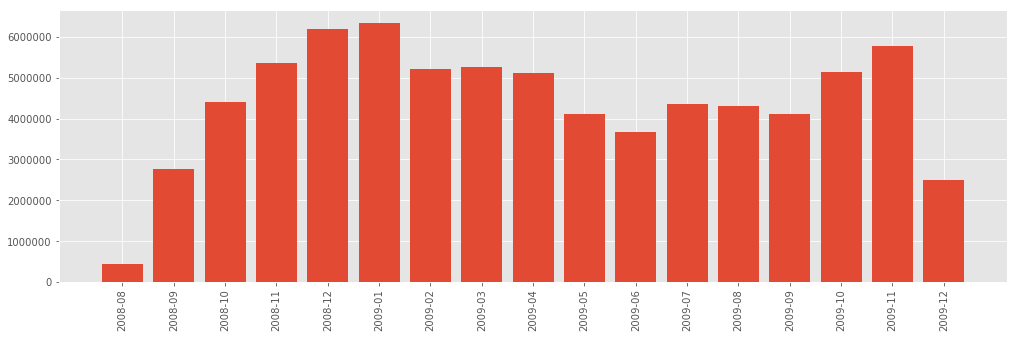

In [12]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()

X=grupo.values
Y=grupo.index

plt.figure(figsize=(17,5))
plt.bar(range(len(X)), X)
plt.xticks(np.arange(len(X)), Y,rotation='vertical')
plt.show()

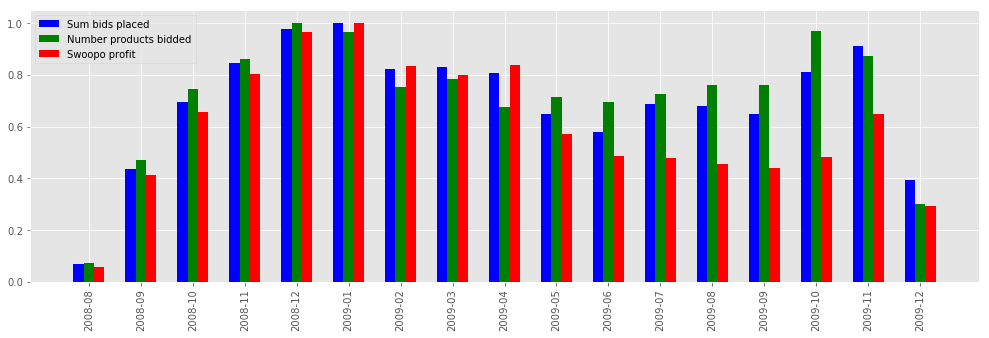

In [37]:
f = lambda x: str(x.year) + '-' + '{0:02d}'.format(x.month)

sumBidsPlacedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()
countProductsBiddedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].count()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumBidsPlacedGroup.index
Y=sumBidsPlacedGroup.values
Y2 = countProductsBiddedGroup.values
Y3 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y/max(Y), bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2/max(Y2),bar_width, color='g')
p3=plt.bar(np.arange(len(Y3))+2*bar_width,Y3/max(Y3),bar_width, color='r')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2,p3),('Sum bids placed','Number products bidded', 'Swoopo profit'))
plt.show()

In [16]:
np.arange(4)

array([0, 1, 2, 3])

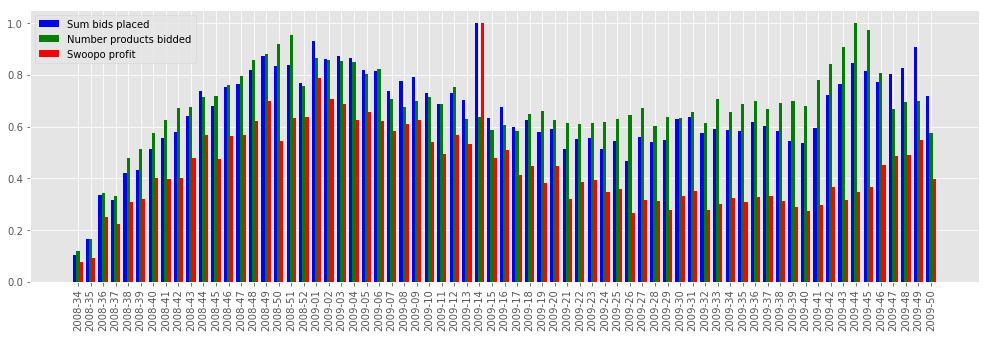

In [41]:
def timeStampToYearWeekFormat(timestamp):
    
    #for index_val, series_val in timeStampSeries.iteritems():
    yearWeekFormatString = str(timestamp.year) + '-' + '{0:02d}'.format(timestamp.weekofyear)
    if yearWeekFormatString == '2008-01':
        #Convert 2008-01 to 2009-01, because some days of the last week of 
        #a year are considered to be in the first week of the next year, 
        #and the data timestamps range from '2008-08-20 14:04:00' to '2009-12-12 15:10:00'
        #The ISO 8601 definition for week 01 is the week with the year's first Thursday in it.
        yearWeekFormatString = '2009-01'
    return yearWeekFormatString
    
sumBidsPlacedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['bids_placed'].sum()
countProductsBiddedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['bids_placed'].count()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['swoopo_profit'].sum()

X=sumBidsPlacedGroup.index
Y=sumBidsPlacedGroup.values
Y2 = countProductsBiddedGroup.values
Y3 = swoopoProfitGroup.values
bar_width = 0.25

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y/max(Y), bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2/max(Y2),bar_width, color='g')
p3=plt.bar(np.arange(len(Y3))+2*bar_width,Y3/max(Y3),bar_width, color='r')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2,p3),('Sum bids placed','Number products bidded', 'Swoopo profit'))
plt.show()


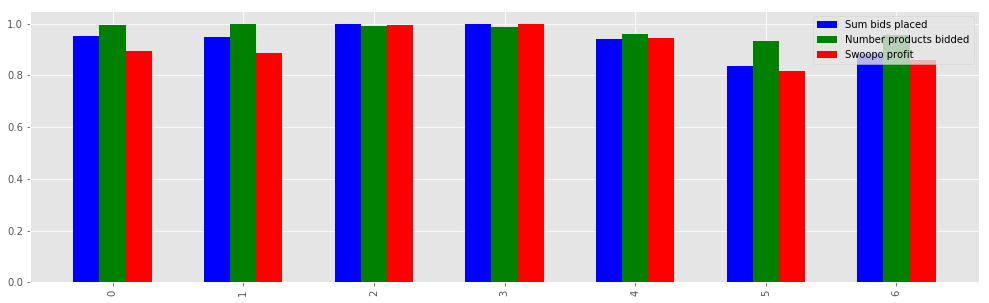

In [38]:
f = lambda x: str(x.dayofweek)

sumBidsPlacedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].sum()
countProductsBiddedGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['bids_placed'].count()
swoopoProfitGroup = outcomesDf.groupby(outcomesDf['endtime_str'].apply(f))['swoopo_profit'].sum()

X=sumBidsPlacedGroup.index
Y=sumBidsPlacedGroup.values
Y2 = countProductsBiddedGroup.values
Y3 = swoopoProfitGroup.values
bar_width = 0.20

plt.figure(figsize=(17,5))
p1=plt.bar(np.arange(len(Y)),Y/max(Y), bar_width,color='b')
p2=plt.bar(np.arange(len(Y2))+bar_width,Y2/max(Y2),bar_width, color='g')
p3=plt.bar(np.arange(len(Y3))+2*bar_width,Y3/max(Y3),bar_width, color='r')
plt.xticks(np.arange(len(X)) + bar_width, X,rotation='vertical')
plt.legend((p1,p2,p3),('Sum bids placed','Number products bidded', 'Swoopo profit'))
plt.show()

In [14]:
def timeStampToYearWeekFormat(timestamp):
    
    #for index_val, series_val in timeStampSeries.iteritems():
    yearWeekFormatString = str(timestamp.year) + '-' + '{0:02d}'.format(timestamp.weekofyear)
    if yearWeekFormatString == '2008-01':
        #Convert 2008-01 to 2009-01, because some days of the last week of 
        #a year are considered to be in the first week of the next year, 
        #and the data timestamps range from '2008-08-20 14:04:00' to '2009-12-12 15:10:00'
        #The ISO 8601 definition for week 01 is the week with the year's first Thursday in it.
        yearWeekFormatString = '2009-01'
    return yearWeekFormatString
    
grupo = outcomesDf.groupby(outcomesDf['endtime_str'].apply(timeStampToYearWeekFormat))['endtime_str']

grupo.unique()


endtime_str
2008-34    [2008-08-23T22:02:00.000000000, 2008-08-24T14:...
2008-35    [2008-08-28T11:17:00.000000000, 2008-08-25T11:...
2008-36    [2008-09-02T06:21:00.000000000, 2008-09-02T00:...
2008-37    [2008-09-08T08:26:00.000000000, 2008-09-14T23:...
2008-38    [2008-09-16T19:52:00.000000000, 2008-09-18T10:...
2008-39    [2008-09-23T10:08:00.000000000, 2008-09-23T18:...
2008-40    [2008-10-04T00:59:00.000000000, 2008-09-29T22:...
2008-41    [2008-10-10T13:32:00.000000000, 2008-10-08T05:...
2008-42    [2008-10-15T09:50:00.000000000, 2008-10-17T10:...
2008-43    [2008-10-21T09:28:00.000000000, 2008-10-25T08:...
                                 ...                        
2009-41    [2009-10-05T10:51:00.000000000, 2009-10-05T01:...
2009-42    [2009-10-12T00:00:00.000000000, 2009-10-12T00:...
2009-43    [2009-10-19T06:13:00.000000000, 2009-10-19T06:...
2009-44    [2009-10-27T13:55:00.000000000, 2009-10-30T14:...
2009-45    [2009-11-02T00:18:00.000000000, 2009-11-02T06:...
2009-46    [

In [7]:
outcomesDf['winner'].value_counts()

HH0812          131
Oglalasioux     117
Toertchen       116
Koboldwicht     112
Schlumpf01      111
Kavvamartin     111
Thomsen321      109
Brusher         108
Aluf412         108
Trixi101        106
Maths           105
18rudi61        104
HFW-BW          104
Samurai38       103
1pleitegeier    102
waggerl         102
winni1958       101
canton          101
rasputin900     101
19conny63       101
Kaiserlein99    101
Biggibig        100
kiam20          100
damage24        100
Redfoxz          99
Artemis412       98
Albundy12        98
audt             97
buvosc           97
XX1973XX         95
               ... 
Sinow             1
Ahmedhans         1
Rudnik02          1
Zachias87         1
Abseitsfalle      1
Murdock04         1
Antware           1
Becisoft          1
Larry1968         1
Conmigo27         1
Spearo1985        1
Sandizm           1
Tomb578           1
Emolson           1
Titan1986         1
Srmorgen          1
Tayloa            1
Morzy             1
Monstar13         1


In [8]:
outcomesDf['desc'].value_counts()

20 Bids Voucher                                      6658
Wii | Nintendo Console + Wii Sports                  5935
50 Bids Voucher                                      3283
300 Bids Voucher                                     2365
50 FreeBids Voucher                                  2297
Wii Fit | Nintendo WiiFit + Balance Board            2179
75 Bids Voucher                                      2073
Mario Kart with Wheel (Nintendo Wii)                 1995
DS | Nintendo DS Lite Black                          1754
Sony PlayStation 3 80 GB                             1656
300 FreeBids Voucher                                 1503
Corsair Voyager Mini 4 GB USB Flash                  1452
Apple iPod touch 8 GB (new generation)               1305
Transcend TS8GJFV10 USB 2.0 8GB Flash Drive          1239
Nikon D90 12.3 MP DSLR Camera with 18-105mm Kit      1160
DS | Nintendo DS Lite (silver)                       1113
TomTom Go 930T                                       1048
Kingston DataT

In [6]:
outcomesDf.head()

,auction_id,product_id,item,desc,retail,price,finalprice,bidincrement,bidfee,winner,placedbids,freebids,endtime_str,flg_click_only,flg_beginnerauction,flg_fixedprice,flg_endprice
0,86827,10009602,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,13.35,13.35,15,75,Racer11,26,0,19:52 PDT 09-16-2008,0,0,0,0
1,87964,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,74.70,74.70,15,75,Cemo23,65,0,11:17 PDT 08-28-2008,0,0,0,0
2,87965,10009881,psp-slim-lite-sony-piano-black,PSP Slim & Lite Sony Piano Black,169.99,83.10,83.10,15,75,Jacobsonnich,94,0,22:52 PDT 11-07-2008,0,1,0,0
3,88638,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,19.65,19.65,15,75,Mokkis,10,0,22:02 PDT 08-23-2008,0,0,0,0
4,88639,10006115,sony-ericsson-s500i-unlocked-mysterious-,Sony Ericsson S500i Unlocked Mysterious Green,499.99,47.10,47.10,15,75,Superloeffel,80,0,14:23 PDT 08-24-2008,0,0,0,0


In [6]:
outcomesDf['bidincrement'] = outcomesDf['bidincrement']/100
outcomesDf['bidfee'] = outcomesDf['bidfee']/100

In [7]:
outcomesDf['finalprice_withbids'] = outcomesDf['finalprice'] + outcomesDf['placedbids']*outcomesDf['bidfee']/100

In [8]:
X = outcomesDf[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]].values
y = outcomesDf["finalprice"]

In [9]:
from sklearn.ensemble import RandomForestRegressor
rmodel=RandomForestRegressor()
rmodel.fit(X,y)
outcomesDf['P_finalprice'] = rmodel.predict(outcomesDf[["retail","bidincrement","bidfee","flg_click_only","flg_beginnerauction","flg_fixedprice","flg_endprice"]])

In [10]:
from sklearn.metrics import mean_squared_error
mean_squared_error(outcomesDf["finalprice"],outcomesDf["P_finalprice"])

1573.6795392862487

In [11]:
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(n_neighbors=14)
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

1853.8693434612576

In [12]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=5)
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

2233.3352624535119

In [13]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X, y)
mean_squared_error(outcomesDf["finalprice"],clf.predict(X))

2836.4416671023268

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn.ensemble import RandomForestRegressor

In [16]:
red = decomposition.PCA()
clf = RandomForestRegressor()
pipe = Pipeline(steps=[('pca', red), ('Random Forest',clf)])
pipe.fit(X_train,y_train)
mean_squared_error(y_test,pipe.predict(X_test))

1745.152500657724

In [17]:
rmodel=RandomForestRegressor()
rmodel.fit(X_train,y_train)
mean_squared_error(y_test,rmodel.predict(X_test))

1730.53876673115

In [21]:
#pip install tpot
from tpot import TPOTRegressor
clf = TPOTRegressor(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
clf.fit(X_train, y_train)

Optimization Progress:  35%|███▌      | 42/120 [19:18<23:49, 18.33s/pipeline]  

Generation 1 - Current best internal CV score: -1827.8826756451847


Optimization Progress:  52%|█████▏    | 62/120 [23:34<14:18, 14.80s/pipeline]

Generation 2 - Current best internal CV score: -1823.8761482971022


Optimization Progress:  68%|██████▊   | 82/120 [32:51<11:32, 18.22s/pipeline]

Generation 3 - Current best internal CV score: -1816.638711479889


Optimization Progress:  85%|████████▌ | 102/120 [40:59<08:24, 28.00s/pipeline]

Generation 4 - Current best internal CV score: -1812.5731728550006


Generation 5 - Current best internal CV score: -1809.5113192722783

Best pipeline: RandomForestRegressor(RobustScaler(input_matrix), bootstrap=True, max_features=0.95, min_samples_leaf=8, min_samples_split=9, n_estimators=100)


TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       early_stop=None, generations=5, max_eval_time_mins=5,
       max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
       offspring_size=20, periodic_checkpoint_folder=None,
       population_size=20, random_state=42, scoring=None, subsample=1.0,
       verbosity=2, warm_start=False)

In [24]:
mean_squared_error(y_test,clf.predict(X_test))

1700.5002792679786